Exploring implementation of iSamples model using postgres graph structure.

Major components of the model are separated to facilitate reuse.

In [2]:
import json
import typing
import psycopg
import graphviz

CNSTR = "dbname=isam1_01 user=vieglais"

def execute(commands):
    with psycopg.connect(CNSTR) as cn:
        with cn.cursor() as csr:
            for s in commands:
                csr.execute(s)
                cn.commit()

def doquery(sql, *args):
    with psycopg.connect(CNSTR) as cn:
        with cn.cursor() as csr:
            result = csr.execute(sql, *args).fetchall()
    return result

def show_graph(nlights=[], elights=[]):
    nodes = doquery("""SELECT 
        id, array_agg(guids.guid), ttype, things.properties->>'name' AS name 
        FROM things 
        JOIN guids ON guids.thing_id=things.id 
        GROUP BY id;
    """)
    _nl = "\\n"
    dst = [
        "digraph {", 
        "node [shape=record, fontname=\"JetBrains Mono\", fontsize=10];",
        "edge [fontname=\"JetBrains Mono\", fontsize=8];"
    ]
    for node in nodes:
        #print(node)
        color = ''
        if node[0] in nlights:
            color = ',color=red'
        dst.append(f"n_{node[0]} [label=\"" + "{" + f"{_nl.join(node[1])}|is a: {node[2]}|name: {node[3]}" + "}\"" + color + "];")    
    rels = doquery("""SELECT 
        src, gsrc.thing_id, predicate, dst, gdst.thing_id 
        FROM relations 
        JOIN guids gsrc ON src=gsrc.guid 
        JOIN guids gdst ON dst=gdst.guid;
    """)
    for r in rels:
        color = ''
        if r[0] in elights:
            color = ', color=red'
        dst.append(f"n_{r[1]} -> n_{r[4]} [label=\"{r[2]}\"" + color + "];")
    dst.append("}")
    #print("\n".join(dst))
    return graphviz.Source("\n".join(dst))

def sgraph(rows, hcols=[], ecols=[]):
    nh = []
    eh = []
    for row in rows:
        for c in hcols:
            nh.append(row[c])
        for c in ecols:
            eh.append(row[c])
    return show_graph(nlights=nh, elights=eh)


The database schema is composed of five tables:
- `things` is used for entities, an entity is anything that has an identifier and can stand alone as single entity
- `guids` is used for identifiers, since a thing may have more than one identifier
- `relations` is used to capture relationships between identifiers
- `terms` is used to capture distinct terms such as keywords or vocabulary terms that are shared amongs many things
- `things_terms` is used to support the many to many relationship between terms and things.

Each record of `things`, `guids`, `relations`, and `terms` may have arbitrary properties.

A challenge with this approach is the lack of database integrity checks. For example, ensuring that a "subsample_of" relation is between two sample objects. These kinds of integrity checks will need to be placed in code.

May want to add a spat table (spatio-temporal) to assist with discovery. Not really necessary for storage since that will be contained in the JSON as WKT for example.

There is a distinction between expected relations to comprise for example, a physical sample record, and the relations that may exist to other entities, physical samples or otherwise.

The expected, or programmatically pre-determined relations for a common pattern of an expected construct, and thus will need to 
be applied efficiently.  

```
collector
samplingEvent/samplingSite/location
```



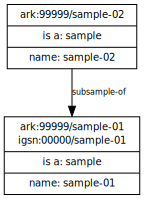

In [3]:
sql = [
"DROP INDEX IF EXISTS things_prop_idx;",
"DROP INDEX IF EXISTS guids_prop_idx;",
"DROP INDEX IF EXISTS relations_prop_idx;",
"DROP INDEX IF EXISTS terms_prop_idx;",
"DROP TABLE IF EXISTS entities",
"DROP TABLE IF EXISTS things_terms;",
"DROP TABLE IF EXISTS terms;",
"DROP TABLE IF EXISTS relations;",
"DROP TABLE IF EXISTS guids;",
"DROP TABLE IF EXISTS things;",
"""CREATE TABLE things (
    id SERIAL PRIMARY KEY, -- internal id of thing
    ttype VARCHAR,         -- type of thing, Sample, Agent, Site, ...
    properties JSONB,      -- All the content of the thing
    parts INT[]            -- things.id values of immediately associated parts of the thing.
);""",
"""CREATE TABLE guids (
    guid VARCHAR PRIMARY KEY,                    -- Globally unique PID, DOI, ARK, ROR, ORCID, ...
    thing_id INTEGER NOT NULL REFERENCES things, -- What thing this PID is associated with
    properties JSONB                             -- A PID may have properties
)""",
"""CREATE TABLE relations (
    src VARCHAR NOT NULL REFERENCES guids (guid), -- The FROM or subject part of relation
    dst VARCHAR NOT NULL REFERENCES guids (guid), -- The TO or object part of the relation
    predicate VARCHAR,                            -- The predicate or type of relation
    properties JSONB,                             -- Additional properties of the relation
    PRIMARY KEY (src, dst, predicate)
);""",
"""CREATE TABLE terms (
    id SERIAL PRIMARY KEY,
    uri VARCHAR NOT NULL,    -- URI for the term
    scheme VARCHAR NOT NULL, -- Scheme that term appears in
    name VARCHAR,            -- Term value, skos:prefLabel
    broader VARCHAR[],       -- URIs pthat are the object of skos:broader
    related VARCHAR[],       -- URIs that are the object of skos:related
    properties JSONB,        -- label, definition, history, etc
    CONSTRAINT term_scheme UNIQUE (scheme, uri)
);""",
"""CREATE TABLE things_terms (
    things_id int REFERENCES things (id),
    terms_id INT REFERENCES terms (id),
    CONSTRAINT things_terms_pkey PRIMARY KEY (things_id, terms_id)
)""",
"CREATE INDEX things_prop_idx on things USING gin(properties);",
"CREATE INDEX guids_prop_idx on guids USING gin(properties);",
"CREATE INDEX relations_prop_idx on relations USING gin(properties);",
"CREATE INDEX terms_prop_idx on terms USING gin(properties);",
]
execute(sql)
# https://dba.stackexchange.com/questions/89451/inserting-into-related-tables
sql = [
    "INSERT INTO things VALUES (DEFAULT, 'sample', '{\"name\":\"sample-01\"}'::jsonb)",
    "INSERT INTO guids VALUES ('ark:99999/sample-01', lastval(), '{}'::jsonb)",
    "INSERT INTO guids VALUES ('igsn:00000/sample-01', lastval(), '{}'::jsonb)",
    "INSERT INTO things VALUES (DEFAULT, 'sample', '{\"name\":\"sample-02\"}'::jsonb)",
    "INSERT INTO guids VALUES ('ark:99999/sample-02', lastval(), '{}'::jsonb)",
    "INSERT INTO relations VALUES ('ark:99999/sample-02', 'ark:99999/sample-01', 'subsample-of', '{}'::jsonb)",
]
execute(sql)
show_graph()

We can use the repository pattern to facilitate CRUD operation for physical samples (and other entities). For example:

```
def add_physical_sample(record:PhysicalSample) -> identifier:
```
Given a physical sample record, decomposes to corresponding things, and adds then to the store. 


```
def get_physical_sample(identifier:str) -> PhysicalSample:
```
Given an identifier, gets the physical sample thing, then populates the expected immediately related components.


An obvious concern of this approach is performance. Each record addition or retrieval involves several queries, however there is far less database load than say, decomposing each entity to triples and working at the triple or quad level for everything.

src guid foo does not exist.


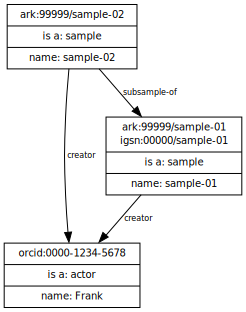

In [4]:
import json

UniqueViolation = psycopg.errors.lookup('23505')

def get_id_from_guid(cursor:psycopg.Cursor, guid:str)-> int:
    cursor.execute("SELECT thing_id FROM guids WHERE guid=%s", (guid,))
    res = cursor.fetchone()
    if res is not None:
        return res[0]
    return None


def add_thing(kind: str, guids: typing.List[str], properties: typing.Any) -> int:
    with psycopg.connect(CNSTR) as cn:
        with cn.cursor() as csr:
            try:
                csr.execute("INSERT INTO things VALUES (DEFAULT, %s, %s) RETURNING id", (kind, json.dumps(properties)))
                last_id = csr.fetchone()[0]
                for guid in guids:
                    csr.execute("INSERT INTO guids VALUES (%s, %s, %s)", (guid, last_id, json.dumps({})))
                cn.commit()
            except psycopg.errors.DatabaseError as e:
                print(e)
                last_id = None
    return last_id


def add_relation(src: str, dst: str, predicate: str, properties: typing.Any, require_existing_targets=True):
    with psycopg.connect(CNSTR) as cn:
        with cn.cursor() as csr:
            # We assume that src and dst are accurate since they may
            # refer to entities outside of the database 
            # e.g. a URI pointing to an external resource
            # Hence, the existence of src and dst is not checked.
            # The combination of src, dst, and predicate should be unique
            # though, and this is checked by the constraint on the table.
            if require_existing_targets:
                # Check that src and dst both exist. If not, raise a value error
                if get_id_from_guid(csr, src) is None:
                    raise ValueError(f"src guid {src} does not exist.")
                if get_id_from_guid(csr, dst) is None:
                    raise ValueError(f"dst guid {dst} does not exist.")
            try:
                sql = "INSERT INTO relations VALUES (%s, %s, %s, %s)"
                csr.execute(sql, (src, dst, predicate, json.dumps(properties)))
                cn.commit()
            except psycopg.errors.DatabaseError as e:
                print(e)

def add_term():
    pass

add_thing("actor", ["orcid:0000-1234-5678",], {"name":"Frank"})
add_relation("igsn:00000/sample-01", "orcid:0000-1234-5678", "creator", None)
add_relation("ark:99999/sample-02", "orcid:0000-1234-5678", "creator", None)
try:
    add_relation("foo", "bar", "test", None)
except ValueError as e:
    # expected
    print(e)
show_graph()